In [0]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

In [0]:
class PolicyContinuous(nn.Module):
    def __init__(self, env):
        super(PolicyContinuous, self).__init__()
        state_space = env.observation_space.shape[0]
        action_space = env.action_space.shape[0]
        num_hidden = 64

        self.l1 = nn.Linear(state_space, num_hidden, bias=False)
        self.l2 = nn.Linear(num_hidden, action_space, bias=False)

        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        self.reset()

    def reset(self):
        # Episode policy and reward history
        self.episode_actions = torch.Tensor([])
        self.episode_rewards = []

    def forward(self, x):
        model = torch.nn.Sequential(
            self.l1,
            nn.ReLU(),
            self.l2,
            #nn.Softmax(dim=-1)
        )
        return model(x)

class AI_Player:
    
  def __init__(self, env, lr=0.01, gamma=1, sigma_start = 10.0, sigma_decay = 0.99):
    super(AI_Player, self).__init__()

    self.policy = PolicyContinuous(env)
    self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
    self.gamma = gamma
    self.sigma = sigma_start
    self.sigma_decay = sigma_decay
    
  def predict(self, state):
    # Select an action (0 or 1) by running policy model
    # and choosing based on the probabilities in state
    state = torch.from_numpy(state).type(torch.FloatTensor)
    action_mean = self.policy(state)
    distribution = Normal(action_mean, self.sigma)
    action = distribution.sample()

    # Add log probability of our chosen action to our history
    self.policy.episode_actions = torch.cat([
        self.policy.episode_actions,
        distribution.log_prob(action).reshape(1)
    ])

    return action 
  
  def update_policy(self):
    R = 0
    rewards = []

    # Discount future rewards back to the present using gamma
    for r in self.policy.episode_rewards[::-1]:
        R = r + self.gamma * R
        rewards.insert(0, R)

    # Scale rewards
    rewards = torch.FloatTensor(rewards)
    rewards = (rewards - rewards.mean()) / \
        (rewards.std() + np.finfo(np.float32).eps)

    # Calculate loss
    loss = (torch.sum(torch.mul(self.policy.episode_actions, rewards).mul(-1), -1))

    # Update network weights
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # Save and intialize episode history counters
    self.policy.loss_history.append(loss.item())
    self.policy.reward_history.append(np.sum(self.policy.episode_rewards))
    self.policy.reset()
    
  def train(self, episodes, max_len = 1000):
    scores = []
    
    for episode in range(episodes):
        # Reset environment and record the starting state
        state = env.reset()
        episode_score = 0

        for time in range(max_len):
            action = self.predict(state)

            # Uncomment to render the visual state in a window
            # env.render()

            # Step through environment using chosen action
            state, reward, done, _ = env.step([action.item()])

            # Save reward
            self.policy.episode_rewards.append(reward)
            episode_score += reward
            
            if done:
              print("Done !")
              break

        self.update_policy()

        # Calculate score to determine when the environment has been solved
        scores.append(episode_score)
        mean_score = np.mean(scores[-100:])

        if episode % 50 == 0:
            print('Episode {}\tAverage reward (last 100 episodes): {:.2f}'.format(
                episode, mean_score))

        if mean_score > env.spec.reward_threshold:
            print("Solved after {} episodes! Average reward is now {}. Last episode ran to a reward of {}."
                  .format(episode, mean_score, episode_score))
            break
            
        self.sigma = self.sigma * self.sigma_decay
  

In [0]:
env = gym.make('MountainCarContinuous-v0')
env.seed(2)
torch.manual_seed(2)
episodes = 500
print(env.spec.reward_threshold)

player = AI_Player(env)

player.train(episodes)

90.0
Done !
Episode 0	Average reward (last 100 episodes): -9317.83
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Episode 50	Average reward (last 100 episodes): -5980.53
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Episode 100	Average reward (last 100 episodes): -4077.66
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
Done !
D

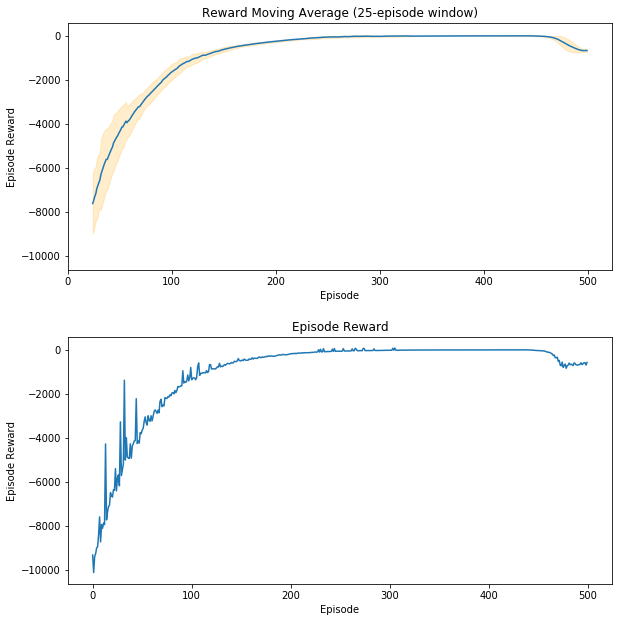

In [0]:
window = int(episodes/20)

fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharey=True, figsize=[9,9]);
rolling_mean = pd.Series(player.policy.reward_history).rolling(window).mean()
std = pd.Series(player.policy.reward_history).rolling(window).std()
ax1.plot(rolling_mean)
ax1.fill_between(range(len(player.policy.reward_history)),rolling_mean-std, rolling_mean+std, color='orange', alpha=0.2)
ax1.set_title('Reward Moving Average ({}-episode window)'.format(window))
ax1.set_xlabel('Episode'); ax1.set_ylabel('Episode Reward')

ax2.plot(player.policy.reward_history)
ax2.set_title('Episode Reward')
ax2.set_xlabel('Episode'); ax2.set_ylabel('Episode Reward')

fig.tight_layout(pad=2)
plt.show()
#fig.savefig('results.png')